In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math

%matplotlib inline

# Example of Proper Cohort Valuation

## Contractual Setting Valuation

### Data Set-Up

In [7]:
survival_perc = [100.0, 64.3, 50.2, 41.5, 35.6, 31.1, 28.2, 25.4, 23.1, 21.0, 19.5, 19.5, 17.9]

CAC = 100 # Customer Acquisition Cost
AOR = 1.8  # Average Order Rate
RPO = 57.3 # Revenue per Order
CM = .26 # Contribution Margin
M = AOR * RPO * CM # Total Margin
WACC = 0.0153 # Discount Rate

### Data Imputation

In [23]:
St_actual = list(map(lambda x : x / 100, survival_perc))

T = len(St_actual)

Rt_actual = [i / j for i, j in zip(St_actual[1:T], St_actual[0:(T-1)])]
Rt_actual

lsts = {"month": range(1, T + 1), "St_actual": St_actual, "Rt_actual": [None] + Rt_actual}

d = pd.DataFrame(lsts)

t_calib = 6

In [38]:
d["Rt_actual"].iloc[1:]

1     0.643000
2     0.780715
3     0.826693
4     0.857831
5     0.873596
6     0.906752
7     0.900709
8     0.909449
9     0.909091
10    0.928571
11    1.000000
12    0.917949
Name: Rt_actual, dtype: float64

### Function Defs

In [39]:
def G_rt_sse(logit_theta: float, d: pd.DataFrame) -> float:
    theta = 1 / (1 + pow(-logit_theta, math.e))
    return sum(np.power((1 - theta) - d["Rt_actual"].iloc[1:],2))

In [57]:
theta = minimize(G_rt_sse, math.log(.1 / (1 - .1)), d[0:t_calib + 1])
theta["x"][0]
geom_theta_nls = 1 / (1 + pow(-theta["x"][0], math.e))
geom_theta_nls

0.18523540024562138

Text(0.5, 0, 'Months (Since Acquisition)')

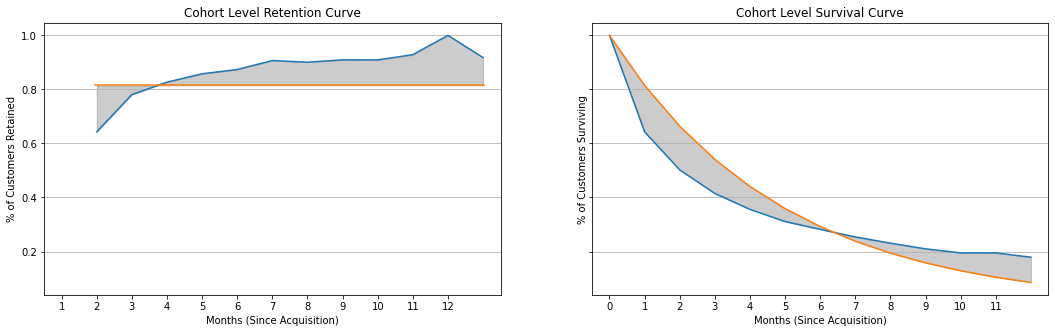

In [152]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(18, 5))

ax1.plot(d["month"], d["Rt_actual"])
ax1.axhline(1-geom_theta_nls, xmin = 1.5/13.5, xmax = 13/13.5, color = "C1")
ax1.fill_between(d["month"], d["Rt_actual"], 1 - geom_theta_nls, color = (0,0,0,0.2))
ax1.set_xlim(0.5, 13.5)
ax1.set_xticks(range(1, 13))
ax1.grid(axis = "y")
ax1.title.set_text("Cohort Level Retention Curve")
ax1.set_ylabel("% of Customers Retained")
ax1.set_xlabel("Months (Since Acquisition)")

ax2.plot(d.index, d["St_actual"])
ax2.plot(d.index, np.power(1 - geom_theta_nls, range(0, T)))
ax2.fill_between(d.index, d["St_actual"], np.power(1 - geom_theta_nls, range(0, T)), color = (0,0,0,0.2))
ax2.set_xlim(-0.5, 12.5)
ax2.set_xticks(range(0, 12))
ax2.grid(axis = "y")
ax2.title.set_text("Cohort Level Survival Curve")
ax2.set_ylabel("% of Customers Surviving")
ax2.set_xlabel("Months (Since Acquisition)")
